In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
# import re
import random
import pickle
import datasets as dst
import conf as cf

import sklearn as skl
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix


In [2]:
# date au format 2023_03_28
def read_df(date :str):
    df = pd.read_csv("C:/Users/Olivier/greta/projet_julien/MeteoVelib/data/datasets/stations_statusV2_"+date+".zip")
    df['time'] = pd.to_datetime(df['time'])
    df = df.drop(["Unnamed: 0"] , axis=1)

    return df

In [3]:
df0=read_df("2023_03_18")
df1=read_df("2023_03_19")
df2=read_df("2023_03_20")
df3=read_df("2023_03_21")
df4=read_df("2023_03_22")
df5=read_df("2023_03_23")
df6=read_df("2023_03_24")
df7=read_df("2023_03_25")
df8=read_df("2023_03_26")
df9=read_df("2023_03_27")
df10=read_df("2023_03_28")

In [94]:
df_tot=pd.concat([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10])

In [4]:
df0.head()

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,...,stationCode,name,lon,lat,altitude,capacity,strike,demonstration,occupation_prct,occupation_class
0,213688169,1,0,1,34,1,1,1,1679092047,2023-03-18 00:00:53,...,16107,Benjamin Godard - Victor Hugo,2.275725,48.865983,52.619041,35,0,1,2.857143,0
1,213688169,1,0,1,34,1,1,1,1679092047,2023-03-18 00:16:55,...,16107,Benjamin Godard - Victor Hugo,2.275725,48.865983,52.619041,35,0,1,2.857143,0
2,213688169,2,1,1,33,1,1,1,1679095761,2023-03-18 00:32:55,...,16107,Benjamin Godard - Victor Hugo,2.275725,48.865983,52.619041,35,0,1,5.714286,1
3,213688169,2,1,1,33,1,1,1,1679095761,2023-03-18 00:48:56,...,16107,Benjamin Godard - Victor Hugo,2.275725,48.865983,52.619041,35,0,1,5.714286,1
4,213688169,3,2,1,32,1,1,1,1679095761,2023-03-18 01:00:57,...,16107,Benjamin Godard - Victor Hugo,2.275725,48.865983,52.619041,35,0,1,8.571429,1


# Correction en 2 parties

On a fait l'hypothèse que les données sont cycliques avec des variations dues à divers facteurs. 
On peut penser que ces facteurs auraient un effet similaires pour différentes stations, et donc refaire une prédiction sur une seule station pour avoir la partie cyclique, et ensuite regarder l'effet sur toutes les stations des autres facteurs sur la différence.

Plan de l'algorithme : 
 - se limiter à juste un jour (j2) et celui de la semaine précédente (j1)
 - faire une prédiction à partir de j1 pour avoir j2_pred (j'utiliserai directement j1)
 - regarder j2-j2_pred (j'utiliserai j2-j1)
 - tracer en fonction de paramètres à déterminer

In [5]:
def get_difference(df1, df2):

    df1['time']=df1['time']+datetime.timedelta(days=7)
    
#     df2=pd.merge_asof(df2, df1, on='time')
    
    
    df_out=pd.merge_asof(df2.sort_values('time'), df1[['time', 'station_id', 'occupation_prct']].sort_values('time'), 
                             on='time', by='station_id', suffixes=('', '_prev'), direction='nearest')
    
    df_out['occupation_diff']=df_out['occupation_prct']-df_out['occupation_prct_prev']
    
    return df_out

In [6]:
# Ajout de valeurs d'occupation 6h plus tot :

def add_old_values(df, df_old=None):
    dec1=6*3 #on a une valeur toutes les 20 minutes, et on regarde 6 heures avant
    dec2=6*3+24*3 #on a une valeur toutes les 20 minutes, et on regarde 6+24 heures avant


    if df_old is None:
        df_main=df.copy()
    else : 
        df_main=pd.concat([df_old, df])
        
    df_main["occupation_diff"]=df_main["occupation_prct"].shift(periods=dec1, axis=0)-df_main["occupation_prct"].shift(periods=dec2, axis=0)

   
    df_main=df_main[df_main['jour'] == df['jour'].median()]
    
    
    return df_main

In [7]:
# train : df2 df9
# test :  df3 df10

In [8]:
df2=read_df("2023_03_20")
df3=read_df("2023_03_21")
df9=read_df("2023_03_27")
df10=read_df("2023_03_28")

df_train=get_difference(df2, df9)
df_test=get_difference(df3, df10)


In [9]:
# foo.head()

In [10]:
df_train.dtypes


station_id                           int64
num_bikes_available                  int64
num_bikes_available_mech             int64
num_bikes_available_elec             int64
num_docks_available                  int64
is_installed                         int64
is_returning                         int64
is_renting                           int64
last_reported                        int64
time                        datetime64[ns]
weekday                              int64
year                                 int64
month                                int64
day                                  int64
hour                                 int64
minute                               int64
weather                             object
temperature                        float64
humidity                             int64
visibility                           int64
wind_speed                         float64
wind_deg                             int64
clouds                               int64
stationCode

In [11]:
feat=['station_id','lon', 'lat', 'altitude', 'day', 'weekday', 'hour', 'minute', 'temperature', 'humidity']
target=['occupation_diff']
both=['station_id','lon', 'lat', 'altitude', 'day', 'weekday', 'hour', 'minute', 'temperature', 'humidity', 'occupation_diff']

foo=df_train[both].dropna()
x_train=foo[feat]
y_train=foo[target]

foo=df_test[both].dropna()
x_test=foo[feat]
y_test=foo[target]

# x_train=df_train[feat]
# x_test=df_test[feat]
# y_train=df_train[target]
# y_test=df_test[target]

In [12]:
import seaborn as sns

<AxesSubplot:xlabel='humidity', ylabel='occupation_diff'>

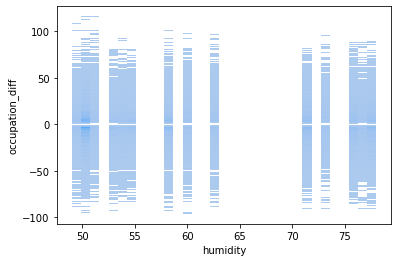

In [13]:
sns.histplot(x='humidity', y='occupation_diff', data=df_train)

<AxesSubplot:xlabel='hour', ylabel='occupation_diff'>

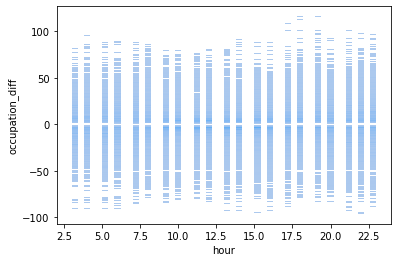

In [14]:
sns.histplot(x='hour', y='occupation_diff', data=df_train)

<AxesSubplot:xlabel='lat', ylabel='occupation_diff'>

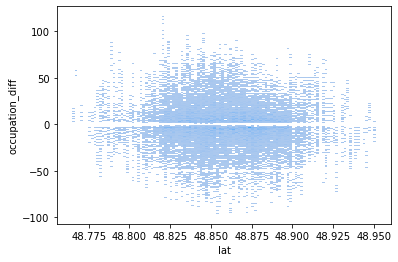

In [15]:
sns.histplot(x='lat', y='occupation_diff', data=df_train)

<AxesSubplot:xlabel='lon', ylabel='occupation_diff'>

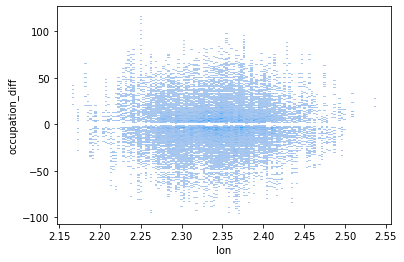

In [16]:
sns.histplot(x='lon', y='occupation_diff', data=df_train)

In [17]:
import sklearn as skl
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error

In [18]:
clf = GradientBoostingRegressor(random_state=0)
clf.fit(x_train, y_train.values.ravel())

y_pred = clf.predict(x_test)

MAE: 14.97
MSE: 448.606


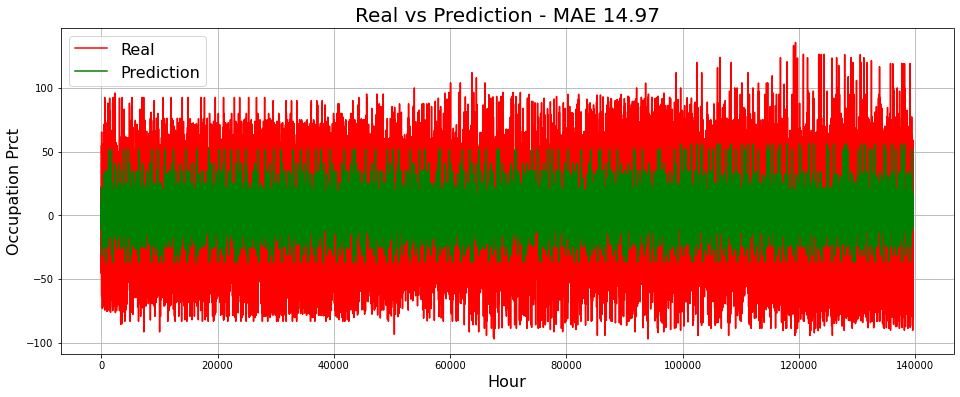

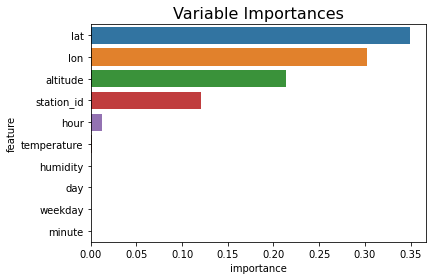

In [46]:
# def plot_error(x_train0, y_train0, y_test0, y_pred0) :

# #     ind=x_train0['station_error'] == station_info[]

mae = np.round(mean_absolute_error(y_test, y_pred), 3)
mse = np.round(mean_squared_error(y_test, y_pred), 3)


print("MAE:", mae)
print("MSE:", mse)

#plot reality vs prediction for the last week of the dataset
fig = plt.figure(figsize=(16,6))
plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
plt.plot(y_test, color='red')
plt.plot(pd.Series(y_pred, index = y_test.index), color='green')

plt.xlabel('Hour', fontsize = 16)
plt.ylabel('Occupation Prct', fontsize = 16)
plt.legend(labels=['Real', 'Prediction', 'Last week'], fontsize = 16)


plt.grid()
plt.show()

#create a dataframe with the variable importances of the model
df_importances = pd.DataFrame({
    'feature': clf.feature_names_in_,
    'importance': clf.feature_importances_
}).sort_values(by='importance', ascending=False)

#plot variable importances of the model
plt.title('Variable Importances', fontsize=16)
sns.barplot(x = df_importances.importance, y = df_importances.feature, orient='h')
plt.show()

In [90]:
#y train, test, et pred : j2-j1
#y test_base : j2
#y pred_base : ~j1
def plot_error(x_train, y_train, y_test, y_pred, y_test_base, y_pred_base) :

# #     


    mae = np.round(mean_absolute_error(y_test, y_pred), 3)
    mse = np.round(mean_squared_error(y_test, y_pred), 3)


    print("MAE:", mae)
    print("MSE:", mse)

    #plot reality vs prediction 
    #figure de différence
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(y_pred, index = y_test.index), color='green')

    plt.xlabel('Hour', fontsize = 16)
    plt.ylabel('Occupation Prct', fontsize = 16)
    plt.legend(labels=['Real', 'Prediction'], fontsize = 16)

    plt.grid()
    plt.show()

    #figure totale
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test_base, color='red')
    plt.plot(pd.Series(y_pred+y_pred_base, index = y_test.index), color='green')
    plt.plot(pd.Series(y_pred_base, index = y_test.index), color='blue')

    plt.xlabel('Hour', fontsize = 16)
    plt.ylabel('Occupation Prct', fontsize = 16)
    plt.legend(labels=['Real', 'Prediction','Old prediction'], fontsize = 16)

    plt.grid()
    plt.show()
    
    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': clf.feature_names_in_,
        'importance': clf.feature_importances_
    }).sort_values(by='importance', ascending=False)

    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x = df_importances.importance, y = df_importances.feature, orient='h')
    plt.show()

In [91]:
station_list=list(set(df_train.station_id))
station=random.sample(station_list,1)[0]

MAE: 8.954
MSE: 103.349


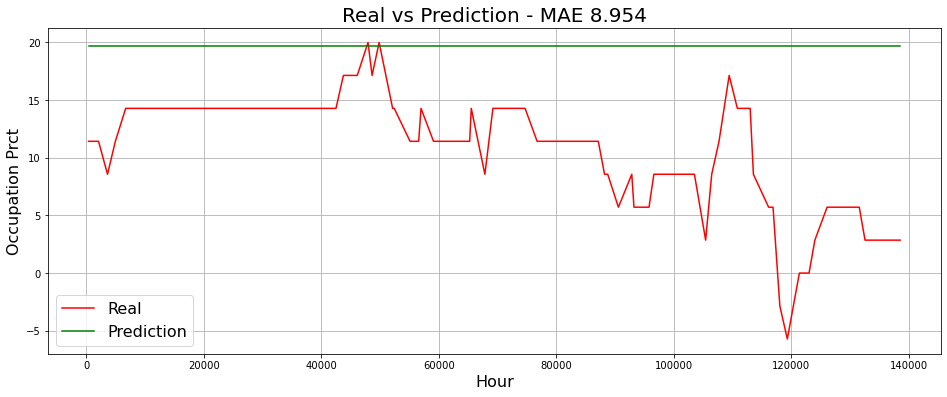

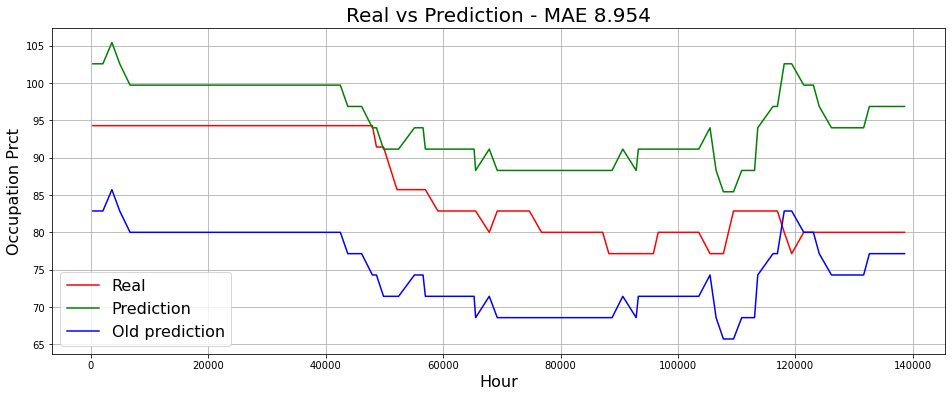

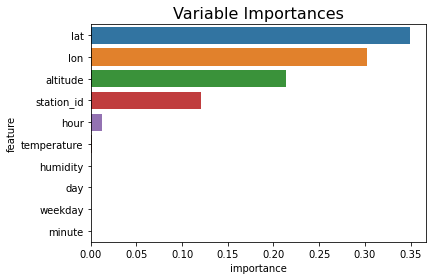

In [92]:
station_list=list(set(df_train.station_id))
station=random.sample(station_list,1)[0]

df_train_mono=df_train[df_train['station_id'] == station]
df_test_mono=df_test[df_test['station_id'] == station]

# df_train_mono[feat].shape, df_train_mono[target].shape, df_test_mono[target].shape, clf.predict(df_test_mono[feat]).shape

# clf_base= GradientBoostingRegressor(random_state=0)
# feat0=['day', 'weekday', 'hour','minute']
# clf_base.fit(df_train_mono[feat0], df_train_mono[target].values.ravel())
# y_pred_base=clf_base.predict(df_test_mono[feat0])
y_pred_base=df_test_mono['occupation_prct_prev']

plot_error(df_train_mono[feat], df_train_mono[target], df_test_mono[target], clf.predict(df_test_mono[feat]), df_test_mono['occupation_prct'], y_pred_base)


MAE: 12.239
MSE: 269.718


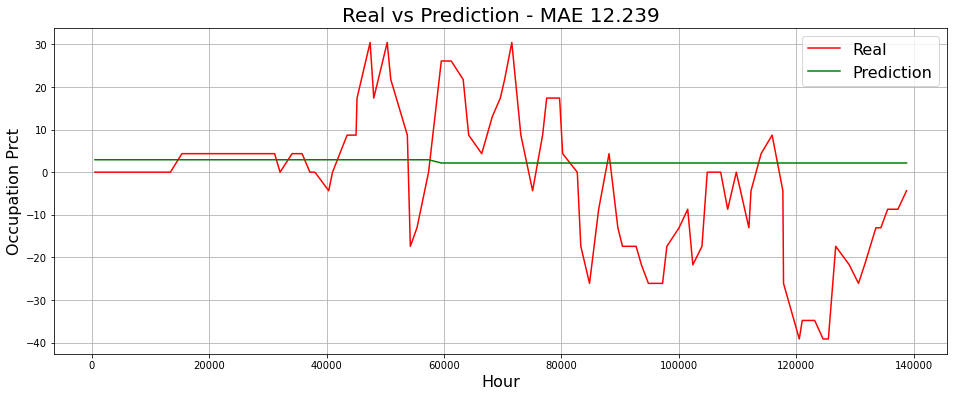

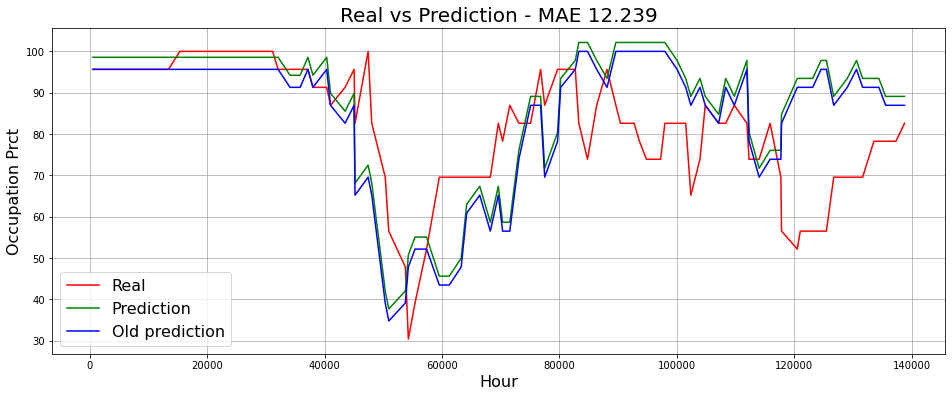

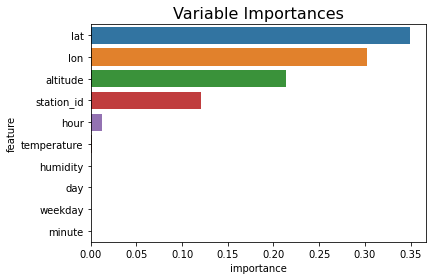

In [93]:
station_list=list(set(df_train.station_id))
station=random.sample(station_list,1)[0]

df_train_mono=df_train[df_train['station_id'] == station]
df_test_mono=df_test[df_test['station_id'] == station]

# df_train_mono[feat].shape, df_train_mono[target].shape, df_test_mono[target].shape, clf.predict(df_test_mono[feat]).shape

# clf_base= GradientBoostingRegressor(random_state=0)
# feat0=['day', 'weekday', 'hour','minute']
# clf_base.fit(df_train_mono[feat0], df_train_mono[target].values.ravel())
# y_pred_base=clf_base.predict(df_test_mono[feat0])
y_pred_base=df_test_mono['occupation_prct_prev']

plot_error(df_train_mono[feat], df_train_mono[target], df_test_mono[target], clf.predict(df_test_mono[feat]), df_test_mono['occupation_prct'], y_pred_base)


MAE: 9.091
MSE: 155.304


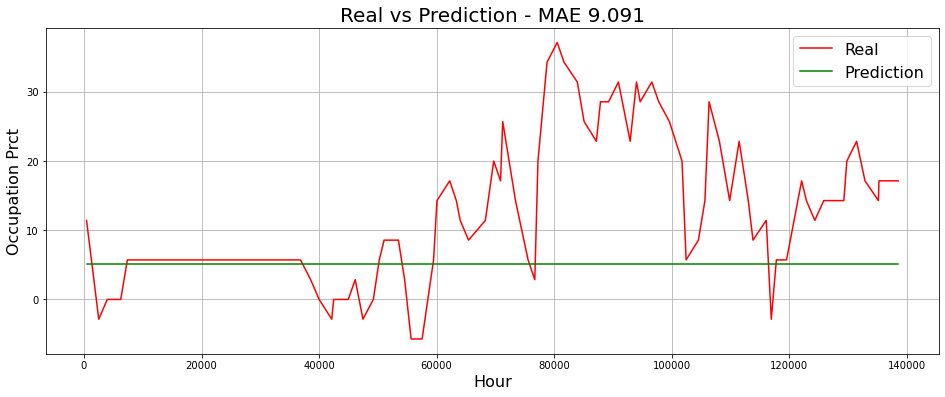

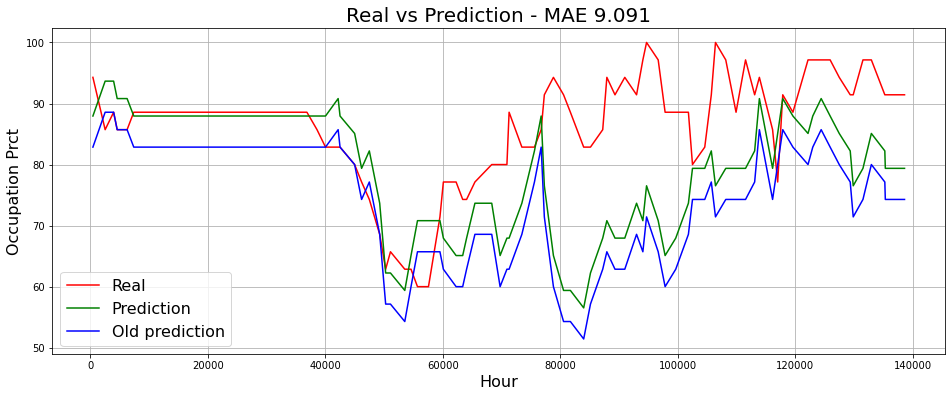

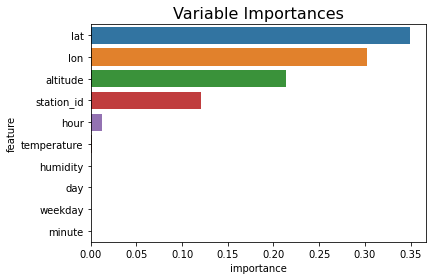

In [103]:
station_list=list(set(df_train.station_id))
station=random.sample(station_list,1)[0]

df_train_mono=df_train[df_train['station_id'] == station]
df_test_mono=df_test[df_test['station_id'] == station]

# df_train_mono[feat].shape, df_train_mono[target].shape, df_test_mono[target].shape, clf.predict(df_test_mono[feat]).shape

# clf_base= GradientBoostingRegressor(random_state=0)
# feat0=['day', 'weekday', 'hour','minute']
# clf_base.fit(df_train_mono[feat0], df_train_mono[target].values.ravel())
# y_pred_base=clf_base.predict(df_test_mono[feat0])
y_pred_base=df_test_mono['occupation_prct_prev']

plot_error(df_train_mono[feat], df_train_mono[target], df_test_mono[target], clf.predict(df_test_mono[feat]), df_test_mono['occupation_prct'], y_pred_base)


MAE: 21.327
MSE: 727.569


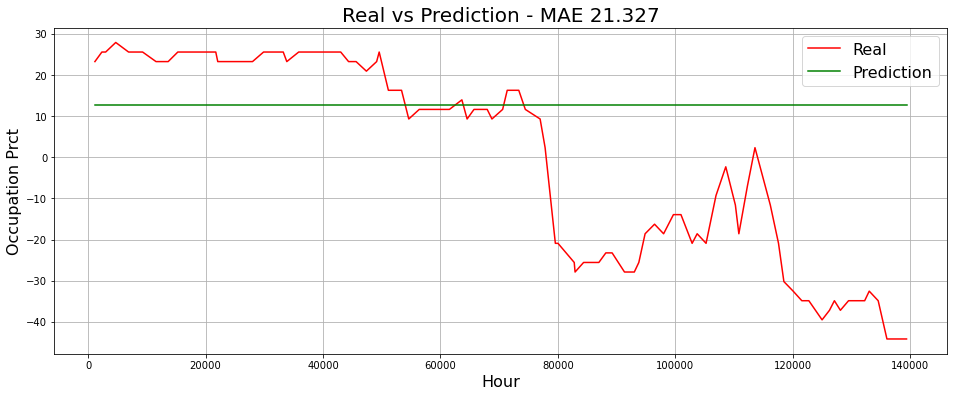

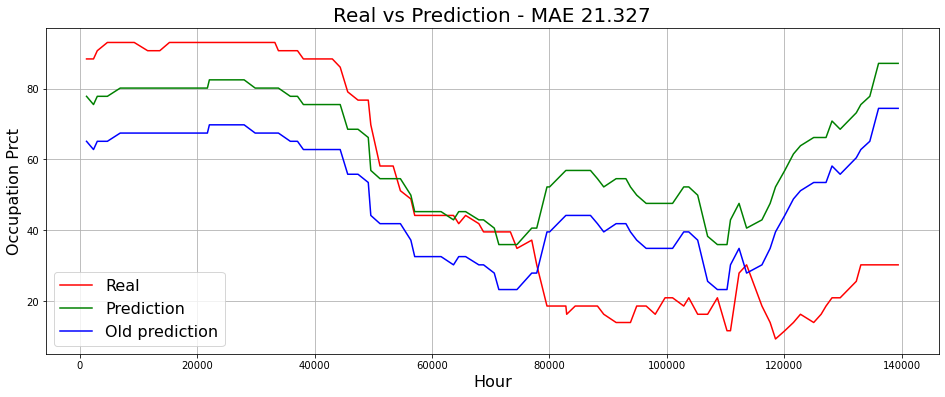

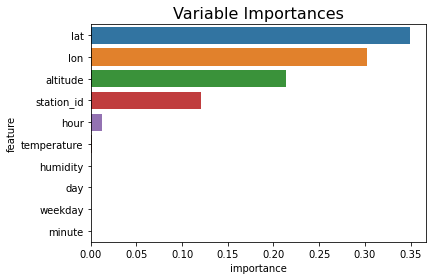

In [104]:
station_list=list(set(df_train.station_id))
station=random.sample(station_list,1)[0]

df_train_mono=df_train[df_train['station_id'] == station]
df_test_mono=df_test[df_test['station_id'] == station]

# df_train_mono[feat].shape, df_train_mono[target].shape, df_test_mono[target].shape, clf.predict(df_test_mono[feat]).shape

# clf_base= GradientBoostingRegressor(random_state=0)
# feat0=['day', 'weekday', 'hour','minute']
# clf_base.fit(df_train_mono[feat0], df_train_mono[target].values.ravel())
# y_pred_base=clf_base.predict(df_test_mono[feat0])
y_pred_base=df_test_mono['occupation_prct_prev']

plot_error(df_train_mono[feat], df_train_mono[target], df_test_mono[target], clf.predict(df_test_mono[feat]), df_test_mono['occupation_prct'], y_pred_base)


In [ ]:
df_train[df_train['station_id'] == station]

# Autre approche : ajout de l'écart quelques heures avant

In [21]:
#On suppose qu'on a déja 
def add_old_difference(df1, df2):

    df1['time']=df1['time']+datetime.timedelta(days=7)
    
#     df2=pd.merge_asof(df2, df1, on='time')
    
    
    df_out=pd.merge_asof(df2.sort_values('time'), df1[['time', 'station_id', 'occupation_prct']].sort_values('time'), 
                             on='time', by='station_id', suffixes=('', '_prev'), direction='nearest')
    
    df_out['occupation_diff']=df_out['occupation_prct']-df_out['occupation_prct_prev']
    
    return df_out

In [100]:

# Charger le DataFrame contenant les données
def use_old_values(df):

    df['jour']=
    
    # Ajouter des colonnes pour les valeurs précédentes
    for i in range(1, 4):
        df[f'occupation_prct_t-{i}'] = df['occupation_prct'].shift(i)

    # Ajouter une colonne pour la moyenne des valeurs précédentes
    df['occupation_prct_mean'] = df[['occupation_prct_t-1', 'occupation_prct_t-2', 'occupation_prct_t-3']].mean(axis=1)

    # Supprimer les premières lignes qui contiennent des valeurs manquantes dues au décalage
    df = df.dropna()

    # Utiliser les nouvelles colonnes comme features pour le modèle
    features = ['day', 'hour', 'weekday', 'minute', 'humidity', 'wind_speed', 'occupation_prct_t-1', 'occupation_prct_t-2', 'occupation_prct_t-3', 'occupation_prct_mean']

    # Diviser le DataFrame en données d'entraînement et de test
    train = df.loc[df['jour'] <= '2023-03-26']
    test = df.loc[df['jour'] >= '2023-03-27']

    # Créer les matrices X_train, y_train, X_test, y_test pour l'entraînement et la validation
    X_train = train[features]
    y_train = train['occupation_prct']
    X_test = test[features]
    y_test = test['occupation_prct']
    
    
    clf.fit(x_train, y_train.values.ravel())
    y_pred=clf.predict(x_test)
    
    
    mae = np.round(mean_absolute_error(y_test, y_pred), 3)
    mse = np.round(mean_squared_error(y_test, y_pred), 3)

    #plot reality vs prediction 

    #figure totale
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(y_pred, index = y_test.index), color='green')
    plt.plot(pd.Series(y_pred, index = y_test.index), color='blue')

    plt.xlabel('Hour', fontsize = 16)
    plt.ylabel('Occupation Prct', fontsize = 16)
    plt.legend(labels=['Real', 'Prediction','Old prediction'], fontsize = 16)

    plt.grid()
    plt.show()
    
    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': clf.feature_names_in_,
        'importance': clf.feature_importances_
    }).sort_values(by='importance', ascending=False)

    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x = df_importances.importance, y = df_importances.feature, orient='h')
    plt.show()
    
    

In [101]:
# station_list=list(set(df_train.station_id))
station=random.sample(station_list,1)[0]

df = df_tot.copy()
df=df[df['station_id'] == station]

use_old_values(df)




TypeError: Invalid comparison between dtype=int64 and str

In [97]:
df.columns

Index(['station_id', 'num_bikes_available', 'num_bikes_available_mech',
       'num_bikes_available_elec', 'num_docks_available', 'is_installed',
       'is_returning', 'is_renting', 'last_reported', 'time', 'weekday',
       'year', 'month', 'day', 'hour', 'minute', 'weather', 'temperature',
       'humidity', 'visibility', 'wind_speed', 'wind_deg', 'clouds',
       'stationCode', 'name', 'lon', 'lat', 'altitude', 'capacity', 'strike',
       'demonstration', 'occupation_prct', 'occupation_class',
       'occupation_prct_t-1', 'occupation_prct_t-2', 'occupation_prct_t-3',
       'occupation_prct_mean'],
      dtype='object')

In [102]:
df.head()

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,...,altitude,capacity,strike,demonstration,occupation_prct,occupation_class,occupation_prct_t-1,occupation_prct_t-2,occupation_prct_t-3,occupation_prct_mean
54048,1023083417,8,7.0,1.0,11,1,1,1,1679092106,2023-03-18 00:00:53,...,43.305122,20,0,1,40.0,2,NaN,NaN,NaN,NaN
54049,1023083417,8,7.0,1.0,11,1,1,1,1679092106,2023-03-18 00:16:55,...,43.305122,20,0,1,40.0,2,40.0,NaN,NaN,40.0
54050,1023083417,8,7.0,1.0,11,1,1,1,1679095632,2023-03-18 00:32:55,...,43.305122,20,0,1,40.0,2,40.0,40.0,NaN,40.0
54051,1023083417,8,7.0,1.0,11,1,1,1,1679095632,2023-03-18 00:48:56,...,43.305122,20,0,1,40.0,2,40.0,40.0,40.0,40.0
54052,1023083417,8,7.0,1.0,11,1,1,1,1679095632,2023-03-18 01:00:57,...,43.305122,20,0,1,40.0,2,40.0,40.0,40.0,40.0


# Retour sur la classification des stations

In [22]:
df=df3
# df=df[df['is_renting'] != 1]


In [23]:
station_list=list(set(df.station_id))
Nst=len(station_list)
Nt=len(set(df[df['station_id'] == station_list[0]].time))
station_timeserie=np.ndarray([Nst,Nt])


In [24]:
for i in range(len(station_list)) :
    station_timeserie[i,:]=df[df['station_id'] == station_list[i]].occupation_prct
    
pd_timeserie=pd.DataFrame(columns=station_list)
for i in range(Nst) :
    pd_timeserie[station_list[i]]=station_timeserie[i,:]

#Remove stations always at 0 or NaN
col_drop=pd_timeserie.loc[:,(pd_timeserie.abs().sum() == 0)]
pd_timeserie=pd_timeserie.drop(columns=col_drop)
    

In [190]:
co=pd_timeserie.corr()

<AxesSubplot:>

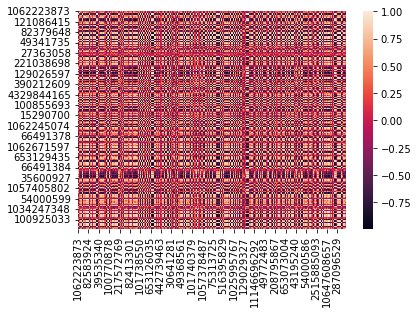

In [191]:
sns.heatmap(co)

In [192]:
pd_timeserie2=pd_timeserie.copy()
col=pd_timeserie2.columns.values
col_sorted=[x for _, x in sorted(zip(co.sum().values, col))]
# col_sorted=pd_timeserie2.columns.values
# col_sorted

<AxesSubplot:>

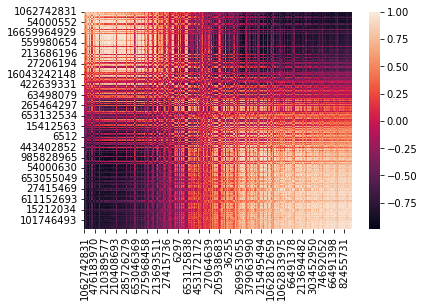

In [193]:
sns.heatmap(co2)


In [194]:
#On va classer les colonnes en fonction de leur corrélation avec une des stations qui correspond à 1 des 2 gros blocs

def corr_pearson(x,y) : 
    xcorr=(x-np.mean(x))/np.std(x)
    
#     ind=(x == x ) and (y == y)
    
    res=np.correlate(xcorr,y)
    return res
    

stat_id_left=1062807847
# array_co=co2.to_numpy()
list_co=np.zeros(Nst)

vec_comp=np.squeeze(co2[co2.index == stat_id_left])

i=0
for k,v in co2.iterrows():
    list_co[i]=corr_pearson(v, vec_comp)
    i+=1

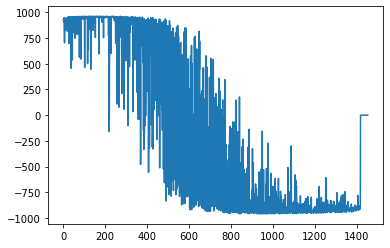

In [195]:
list_co
plt.plot(list_co)

In [207]:
pd_timeserie3=pd_timeserie2.copy()
col=pd_timeserie3.columns.values
# col_sorted=[x for _, x in sorted(zip(list_co, col))]
col_sorted=[x for _, x in sorted(zip(vec_comp, col))]

pd_timeserie3 = pd_timeserie2.reindex(columns=col_sorted)

co3=pd_timeserie3.corr()
# co3=co3.drop(columns=dr).drop(index=dr)

<AxesSubplot:>

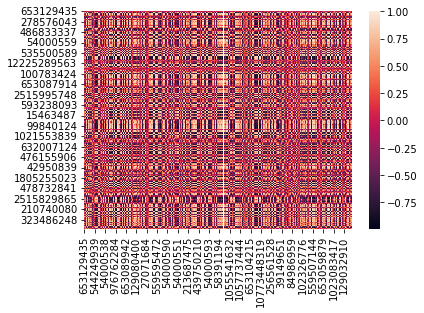

In [208]:
sns.heatmap(co3)

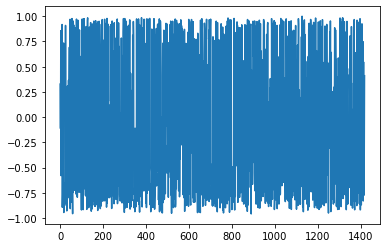

In [209]:
# plt.plot(vec_comp.to_list())
plt.plot(np.squeeze(co3[co3.index == stat_id_left]).to_list())


In [236]:
# foo=[x for _ , x in sorted(zip(vec_comp, range(vec_comp.shape[0])))]
# plt.plot(vec_comp[foo])

# foo=[vec_comp[x] for _ , x in sorted(zip(vec_comp, col))]
# vec_comp[]
# col
# foo

col
vec_comp[[col]]

KeyError: "None of [Index([(1062223873, 85008390, 653197324, 216039437, 653123610, 100859941, 210583589, 2515976231, 488980540, 85155919, 1062797394, 39149651, 102309973, 129081441, 559980654, 1057210479, 213680246, 15401095, 126050442, 82550925, 213688462, 76488849, 653205656, 80101533, 214122655, 214114469, 80216231, 268976295, 85147829, 42950839, 653066427, 224256188, 653156540, 125370566, 1062256852, 129089749, 210387163, 263610599, 101753100, 101761298, 653107480, 109609241, 9931940126, 331153695, 210395439, 35471668, 649888071, 49094984, 357491025, 419381597, 39256416, 102752610, 632086890, 1805255023, 478593396, 82583924, 210567545, 653140345, 15409531, 15163771, 49791363, 34300292, 74858883, 653091206, 244498842, 213680553, 532054446, 653099465, 121086415, 42541542, 101024234, 214139374, 100868590, 213688824, 102326776, 1056965116, 80298493, 245187072, 452936197, 271540743, 30179848, 653050378, 125542925, 129106450, 205955605, 1063404053, 96608796, 336511521, 131908132, 323486248, 478732841, 27206194, 85123644, 1063035479, 102335085, 48800374, 653083263, 653165196, 42566291, 82584215, ...)], dtype='object')] are in the [index]"

In [174]:
foo=co.sum().values
# plt.plot(np.isnan(foo))
np.isnan(foo).any()

False

<AxesSubplot:>

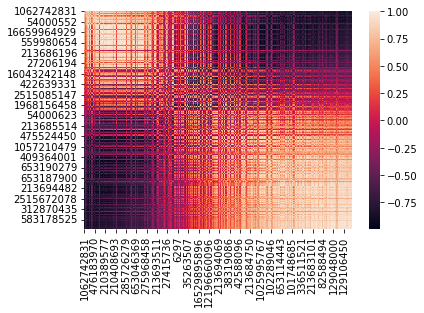

In [244]:
sorted_cols = co.sum().sort_values().index
sorted_corr_matrix = co.loc[sorted_cols, sorted_cols]

sns.heatmap(sorted_corr_matrix)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<AxesSubplot:>

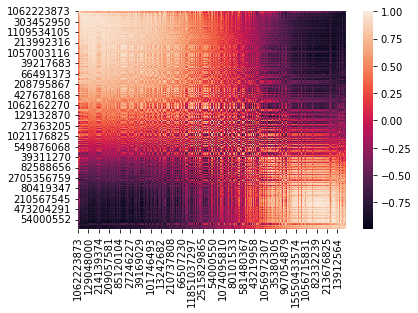

In [247]:

# Generate a correlation matrix
# df = pd.DataFrame(np.random.randn(10, 5), columns=['A', 'B', 'C', 'D', 'E'])
corr_matrix = co

# Sort the columns based on correlation
sorted_cols = [corr_matrix.columns[0]]
i=0
while len(sorted_cols) < len(corr_matrix.columns):
    if i % 100 == 0: 
        print(i)
    i+=1
    remaining_cols = [c for c in corr_matrix.columns if c not in sorted_cols]
    corr_values = corr_matrix.loc[sorted_cols, remaining_cols].sum()
    next_col = corr_values.idxmax()
    sorted_cols.append(next_col)

sorted_corr_matrix = corr_matrix.loc[sorted_cols, sorted_cols]

sns.heatmap(sorted_corr_matrix)

In [248]:
# Sort the columns based on correlation with the first column
sorted_cols = [corr_matrix.columns[0]]
i=0
while len(sorted_cols) < len(corr_matrix.columns):
    if i % 100 == 0: 
        print(i)
    i+=1
    remaining_cols = [c for c in corr_matrix.columns if c not in sorted_cols]
    corr_values = corr_matrix.loc[sorted_cols[0], remaining_cols]
    next_col = corr_values.idxmax()
    sorted_cols.append(next_col)

sorted_corr_matrix2 = corr_matrix.loc[sorted_cols, sorted_cols]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279


KeyError: '[nan] not in index'

In [250]:
sorted_cols.shape


AttributeError: 'list' object has no attribute 'shape'

Le découpage ne peut pas donner 2 blocs complètement nets. Je vais plutot générer pour chaque station un modèle utilisant les sites avec une correlation au dessus d'un certain seuil

In [ ]:
# Define list of station ids
station_ids = list(set(df_train['station_id']))

# Define features
features = ['weekday', 'hour', 'minute']

# Define target variable
target = 'occupation_prct'

# Define dictionary to store evaluation metrics for each station
station_metrics = {}

# Loop through each station
for station_id in station_ids:
    # Subset training and testing data for current station
    train = df_train[df_train['station_id'] == station_id]
    test = df_test[df_test['station_id'] == station_id]

    # Define features and target for current station
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

    # Train Gradient Boosting Regressor on current station
    clf = GradientBoostingRegressor(random_state=0)
    clf.fit(X_train, y_train)

    # Use trained model to predict target on testing data
    y_pred = clf.predict(X_test)

    # Calculate evaluation metrics for current station
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Store evaluation metrics for current station in dictionary
    station_metrics[station_id] = {'MAE': mae, 'MSE': mse}



    
# Define correlation threshold
corr_thresh = 0.8

# Calculate correlation matrix for stations
# corr = df_train.groupby('station_id').corr()
corr=co

# Identify stations with correlation over corr_thresh
corr_stations = corr[corr >= corr_thresh].index.get_level_values(0).unique()

# Define features
features = [['day', 'hour', 'weekday', 'minute', 'humidity', 'wind_speed']]

# Define target variable
target = 'occupation_diff'

# Define dictionary to store evaluation metrics for each station
station_metrics = {}

# Loop through each correlated station
for station_id in corr_stations:
    # Subset training and testing data for current station
    train = df_train[df_train['station_id'] == station_id]
    test = df_test[df_test['station_id'] == station_id]

    # Define features and target for current station
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

